<a href="https://colab.research.google.com/github/cauqqzhang/RasterCor/blob/main/corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
workspace = "/content/drive/MyDrive/GEEMap/" # 上层

In [ ]:
path=workspace+"GEEMap/"

In [ ]:
climatef=workspace+"ALLclimateData93-17_rainfall.csv"

In [ ]:
cf=pd.read_csv(climatef,header=0)
cf

,EVIdate,Rainfall_10dAccumul_1-10advance,Rainfall_10dAccumul_6-15advance,in1,in2,in3
0,19930510,11,43,11,54,2322
1,19930604,0,0,0,0,0
2,19930630,105,47,105,152,7144
3,19930807,473,318,473,791,251538
4,19930924,19,21,19,40,840
...,...,...,...,...,...,...
147,20170528,62,62,62,124,7688
148,20170708,290,278,290,568,157904
149,20170731,593,480,593,1073,515040
150,20170816,141,190,141,331,62890


In [ ]:
outws = os.listdir(path)
outws

In [ ]:
rl1 =outws

In [ ]:
rl1n=[]
for names in rl1:
    if os.path.splitext(names)[1] == '.tif':
        EVIdate = names.split('.')[0]
        rl1n.append(EVIdate)
rl1n=[int(x) for x in rl1n]
rl1n

In [ ]:
rl2=cf[['EVIdate','Rainfall_10dAccumul_1-10advance']]# 1为第二列，修改逐列
rl2

,EVIdate,Rainfall_10dAccumul_1-10advance
0,19930510,11
1,19930604,0
2,19930630,105
3,19930807,473
4,19930924,19
...,...,...
147,20170528,62
148,20170708,290
149,20170731,593
150,20170816,141


In [ ]:
ll=rl2[rl2.EVIdate.isin((rl1n))]
ll

,EVIdate,Rainfall_10dAccumul_1-10advance
0,19930510,11
5,19931017,13
9,19941004,26
14,19960502,0
15,19960721,425
...,...,...
146,20170512,104
147,20170528,62
149,20170731,593
150,20170816,141


In [ ]:
flist=[ '%i.tif' % i for i in ll["EVIdate"]]
flist

In [ ]:
nn=len(flist)

<ipython-input-14-aafae9ce9ee1>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis


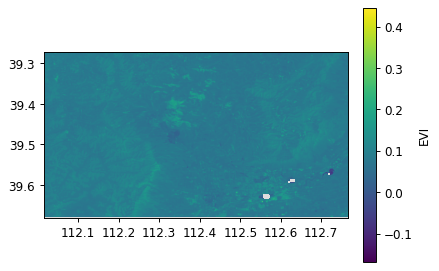

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

ds=gdal.Open(path+flist[0])
nodata = ds.GetRasterBand(1).GetNoDataValue()
data = ds.ReadAsArray()
data = np.ma.masked_values(data, np.nan)
gt = ds.GetGeoTransform()
ys, xs = data.shape
ulx, xres, _, uly, _, yres = gt
extent = [ulx, ulx+xres*xs, uly, uly+yres*ys]
fig, ax = plt.subplots(figsize=(5,6), constrained_layout=True, facecolor='w', dpi=86)

cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis
cmap.set_bad('#dddddd')

im = ax.imshow(data, extent=extent, cmap=cmap)
cb = fig.colorbar(im, shrink=.5)
cb.set_label('EVI')
ds = None

In [ ]:
px=np.empty(data.shape+(nn,), dtype = float, order = 'C')
px.shape

(1525, 2785, 80)

In [ ]:
yraster=ll['Rainfall_10dAccumul_1-10advance'].values

In [ ]:
for ii in range(nn):
  data=gdal.Open(path+flist[ii]).ReadAsArray()
  xraster=np.ma.masked_invalid(data)
  px[:,:,ii]=xraster
  data = None

In [ ]:
def cal_pccs(x, y, n):
    """
    warning: data format must be narray
    :param x: Variable 1
    :param y: The variable 2
    :param n: The number of elements in x
    :return: pccs
    """
    sum_xy = np.sum(np.sum(x*y))
    sum_x = np.sum(np.sum(x))
    sum_y = np.sum(np.sum(y))
    sum_x2 = np.sum(np.sum(x*x))
    sum_y2 = np.sum(np.sum(y*y))
    pcc = (n*sum_xy-sum_x*sum_y)/np.sqrt((n*sum_x2-sum_x*sum_x)*(n*sum_y2-sum_y*sum_y))
    return pcc


In [ ]:
r=[]
for i in range(px.shape[0]):
  for j in range(px.shape[1]):
    r.append(cal_pccs(np.ma.masked_invalid(px[i,j,:]),yraster,nn))
r=np.array(r).reshape((px.shape[0],px.shape[1]))
r[np.isnan(r)] = -9999

<ipython-input-66-002e82fa57dc>:5: UserWarning: Warning: converting a masked element to nan.
  r=np.array(r).reshape((px.shape[0],px.shape[1]))


In [ ]:
roids=gdal.Open(path+flist[0])
prj=roids.GetProjection()
tr=roids.GetGeoTransform()
def savefile(ouf,tr,prj):
  outFileName=ouf
  arr_out=r
  [rows, cols] = arr_out.shape

  driver = gdal.GetDriverByName("GTiff")
  outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
  outdata.SetGeoTransform(tr)##sets same geotransform as input
  outdata.SetProjection(prj)##sets same projection as input
  outdata.GetRasterBand(1).WriteArray(arr_out)
  outdata.GetRasterBand(1).SetNoDataValue(-9999)##if you want these values transparent
  outdata.FlushCache() ##saves to disk!!
  return ouf
outFileName=workspace+"corr.tif"
roids=None
savefile(outFileName,tr,prj)

'/content/drive/MyDrive/GEEMap/corr.tif'

<ipython-input-70-1688d9f72630>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis


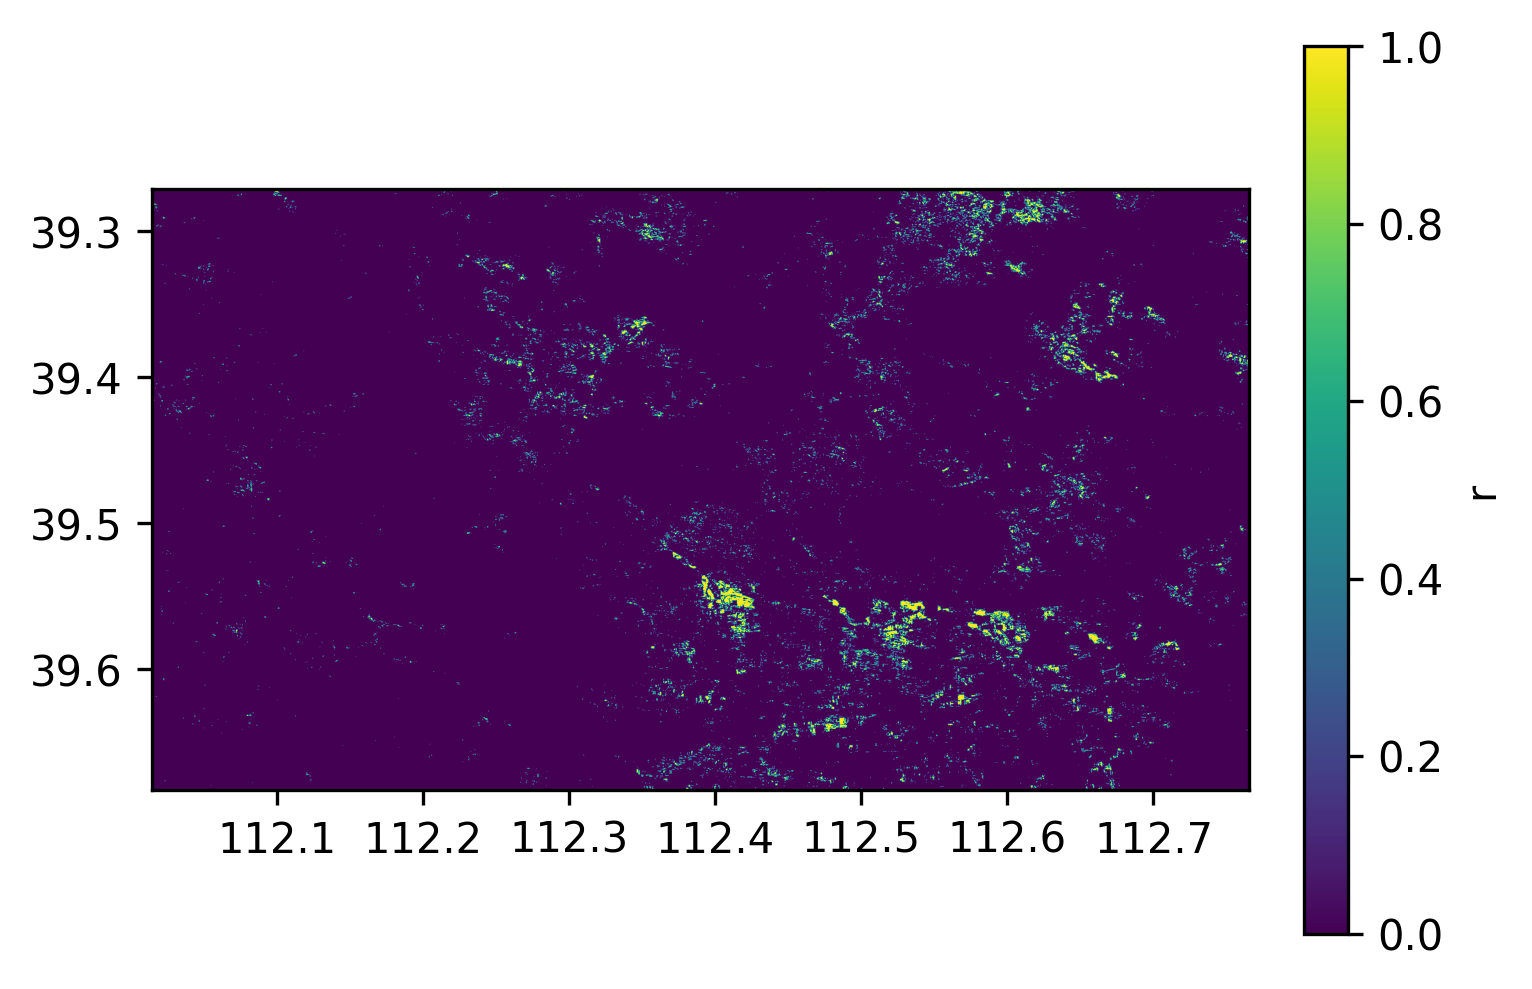

In [ ]:
ds=gdal.Open(outFileName)
nodata = ds.GetRasterBand(1).GetNoDataValue()
data = ds.ReadAsArray()
data = np.ma.masked_values(data, -9999)
gt = ds.GetGeoTransform()
ys, xs = data.shape
ulx, xres, _, uly, _, yres = gt
extent = [ulx, ulx+xres*xs, uly, uly+yres*ys]
fig, ax = plt.subplots(figsize=(5,6), constrained_layout=True, facecolor='w', dpi=300)

cmap = mpl.cm.get_cmap("viridis").copy() # cmap = plt.cm.viridis
cmap.set_bad('#dddddd')

im = ax.imshow(data, extent=extent, cmap=cmap)
cb = fig.colorbar(im, shrink=.5)
cb.set_label('r')
ds = None